# IEEE-CIS Fraud Detection - EDA: Fraud Patterns

**Objective**: Identify key fraud signals in the IEEE-CIS dataset to guide feature engineering.

**Focus Areas**:
- Fraud rate and class distribution
- Top features correlated with fraud
- Missing data patterns
- Transaction amount distribution
- Temporal fraud patterns

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Data Loading and Merging

In [3]:
# Load datasets
DATA_PATH = Path('../../data/raw/')

print("Loading transaction data...")
train_transaction = pd.read_csv(DATA_PATH / 'train_transaction.csv')
print(f"Transaction shape: {train_transaction.shape}")

print("\nLoading identity data...")
train_identity = pd.read_csv(DATA_PATH / 'train_identity.csv')
print(f"Identity shape: {train_identity.shape}")

Loading transaction data...
Transaction shape: (590540, 394)

Loading identity data...
Identity shape: (144233, 41)


In [4]:
# Merge on TransactionID
df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print(f"Merged dataset shape: {df.shape}")
print(f"Total features: {df.shape[1]}")

Merged dataset shape: (590540, 434)
Total features: 434


In [5]:
# Data sample: first 5 columns + top 10 features by correlation with isFraud
preview_cols = df.columns[:5].tolist() + ['V257', 'V246', 'V244', 'V242', 'V201', 
                                           'V200', 'V189', 'V188', 'V258', 'V45']
df[preview_cols].head(15)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,V257,V246,V244,V242,V201,V200,V189,V188,V258,V45
0,2987000,0,86400,68.500,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2987002,0,86469,59.000,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,2987003,0,86499,50.000,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,2987004,0,86506,50.000,H,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
5,2987005,0,86510,49.000,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6,2987006,0,86522,159.000,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
7,2987007,0,86529,422.500,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8,2987008,0,86535,15.000,H,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
9,2987009,0,86536,117.000,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## 2. Fraud Rate Calculation

In [6]:
# Calculate fraud statistics
fraud_count = df['isFraud'].sum()
total_count = len(df)
fraud_rate = fraud_count / total_count * 100

print("="*50)
print("FRAUD STATISTICS")
print("="*50)
print(f"Total transactions: {total_count:,}")
print(f"Fraudulent: {fraud_count:,} ({fraud_rate:.2f}%)")
print(f"Legitimate: {total_count - fraud_count:,} ({100-fraud_rate:.2f}%)")
print(f"\nClass imbalance ratio: 1:{int((total_count-fraud_count)/fraud_count)}")

FRAUD STATISTICS
Total transactions: 590,540
Fraudulent: 20,663 (3.50%)
Legitimate: 569,877 (96.50%)

Class imbalance ratio: 1:27


## 3. Class Distribution Visualization

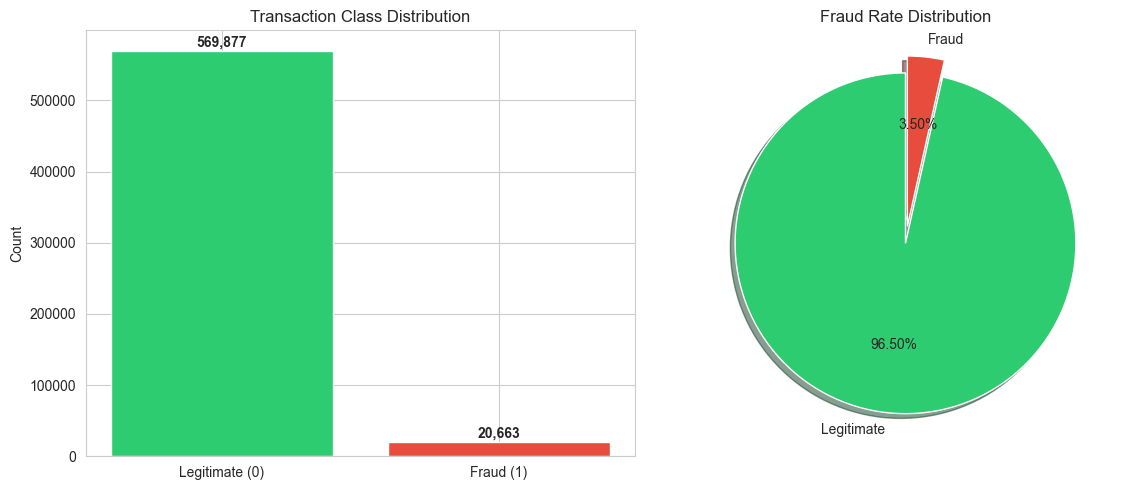

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
class_counts = df['isFraud'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(['Legitimate (0)', 'Fraud (1)'], class_counts.values, color=colors)
axes[0].set_ylabel('Count')
axes[0].set_title('Transaction Class Distribution')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 5000, f'{v:,}', ha='center', fontweight='bold')

# Pie chart (log scale effect via explode)
axes[1].pie([total_count - fraud_count, fraud_count], 
            labels=['Legitimate', 'Fraud'],
            autopct='%1.2f%%', colors=colors, explode=(0, 0.1),
            shadow=True, startangle=90)
axes[1].set_title('Fraud Rate Distribution')

plt.tight_layout()
plt.savefig('../../data/processed/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Top 10 Features by Correlation with isFraud

In [8]:
# Calculate correlations with isFraud (numeric columns only)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('isFraud')
numeric_cols.remove('TransactionID')

correlations = df[numeric_cols].corrwith(df['isFraud']).abs().sort_values(ascending=False)

# Top 10 features
top_10_features = correlations.head(10)
print("TOP 10 FEATURES BY CORRELATION WITH FRAUD")
print("="*50)
for i, (feat, corr) in enumerate(top_10_features.items(), 1):
    print(f"{i:2}. {feat:<20} | Correlation: {corr:.4f}")

TOP 10 FEATURES BY CORRELATION WITH FRAUD
 1. V257                 | Correlation: 0.3831
 2. V246                 | Correlation: 0.3669
 3. V244                 | Correlation: 0.3641
 4. V242                 | Correlation: 0.3606
 5. V201                 | Correlation: 0.3280
 6. V200                 | Correlation: 0.3188
 7. V189                 | Correlation: 0.3082
 8. V188                 | Correlation: 0.3036
 9. V258                 | Correlation: 0.2972
10. V45                  | Correlation: 0.2818


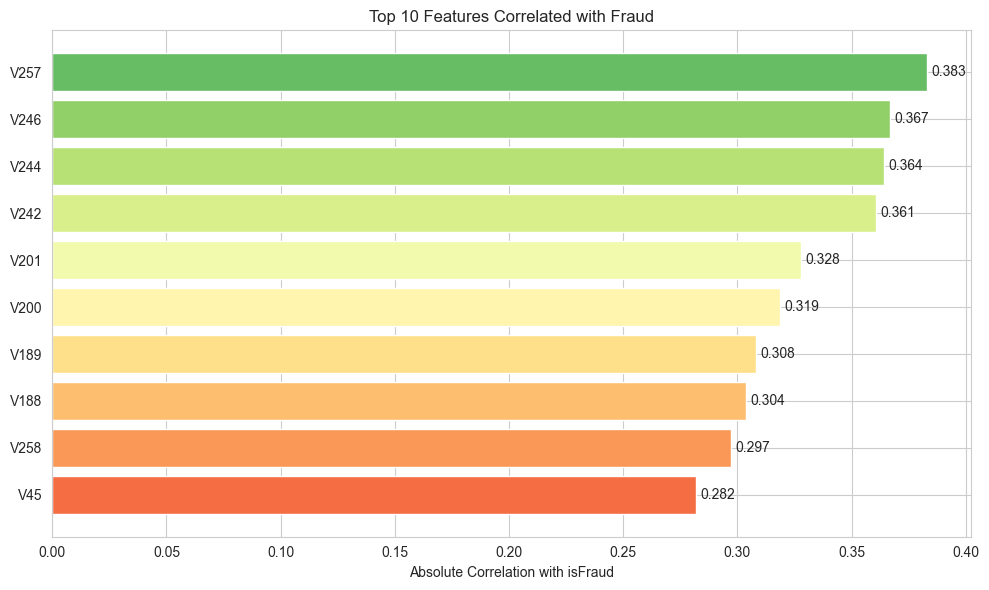

In [9]:
# Visualize top correlations
plt.figure(figsize=(10, 6))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, 10))
bars = plt.barh(top_10_features.index[::-1], top_10_features.values[::-1], color=colors[::-1])
plt.xlabel('Absolute Correlation with isFraud')
plt.title('Top 10 Features Correlated with Fraud')
for bar, val in zip(bars, top_10_features.values[::-1]):
    plt.text(val + 0.002, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center')
plt.tight_layout()
plt.savefig('../../data/processed/top_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Missing Data Analysis

In [10]:
# Calculate missing percentages
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
high_missing = missing_pct[missing_pct > 50]

print(f"FEATURES WITH >50% MISSING DATA: {len(high_missing)}")
print("="*50)
print(f"\nTotal features: {df.shape[1]}")
print(f"Features >50% missing: {len(high_missing)} ({len(high_missing)/df.shape[1]*100:.1f}%)")
print(f"Features >75% missing: {len(missing_pct[missing_pct > 75])}")
print(f"Features >90% missing: {len(missing_pct[missing_pct > 90])}")

FEATURES WITH >50% MISSING DATA: 214

Total features: 434
Features >50% missing: 214 (49.3%)
Features >75% missing: 208
Features >90% missing: 12


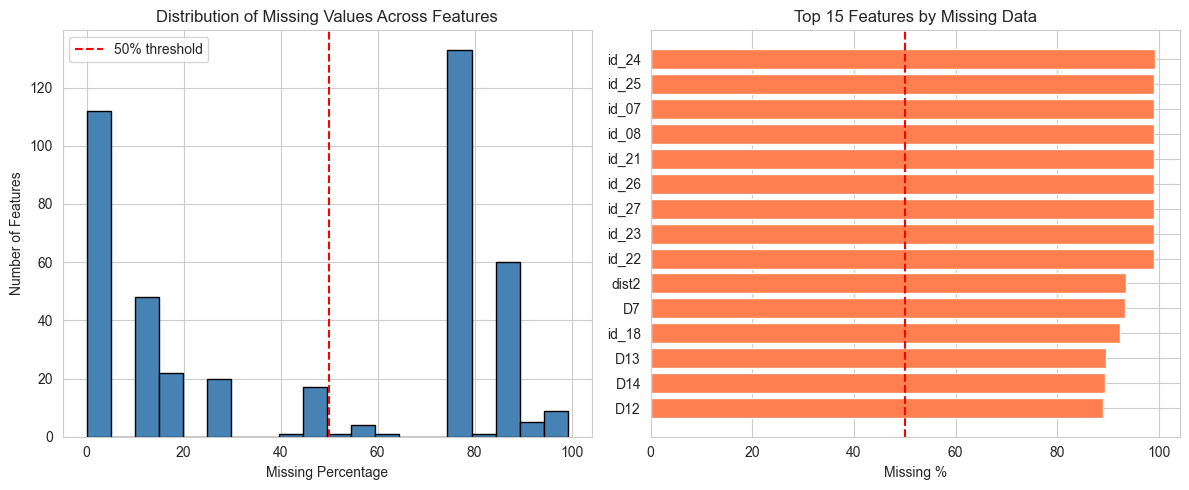

In [11]:
# Visualize missing data distribution
plt.figure(figsize=(12, 5))

# Histogram of missing percentages
plt.subplot(1, 2, 1)
plt.hist(missing_pct, bins=20, color='steelblue', edgecolor='black')
plt.axvline(x=50, color='red', linestyle='--', label='50% threshold')
plt.xlabel('Missing Percentage')
plt.ylabel('Number of Features')
plt.title('Distribution of Missing Values Across Features')
plt.legend()

# Top 15 features with most missing
plt.subplot(1, 2, 2)
top_missing = missing_pct.head(15)
plt.barh(top_missing.index[::-1], top_missing.values[::-1], color='coral')
plt.xlabel('Missing %')
plt.title('Top 15 Features by Missing Data')
plt.axvline(x=50, color='red', linestyle='--')

plt.tight_layout()
plt.savefig('../../data/processed/missing_data.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Transaction Amount Distribution by Fraud Status

In [12]:
# Transaction amount statistics
print("TRANSACTION AMOUNT STATISTICS")
print("="*50)
for label, group in df.groupby('isFraud')['TransactionAmt']:
    status = 'Fraud' if label == 1 else 'Legitimate'
    print(f"\n{status} Transactions:")
    print(f"  Mean:   ${group.mean():,.2f}")
    print(f"  Median: ${group.median():,.2f}")
    print(f"  Std:    ${group.std():,.2f}")
    print(f"  Max:    ${group.max():,.2f}")

TRANSACTION AMOUNT STATISTICS

Legitimate Transactions:
  Mean:   $134.51
  Median: $68.50
  Std:    $239.40
  Max:    $31,937.39

Fraud Transactions:
  Mean:   $149.24
  Median: $75.00
  Std:    $232.21
  Max:    $5,191.00


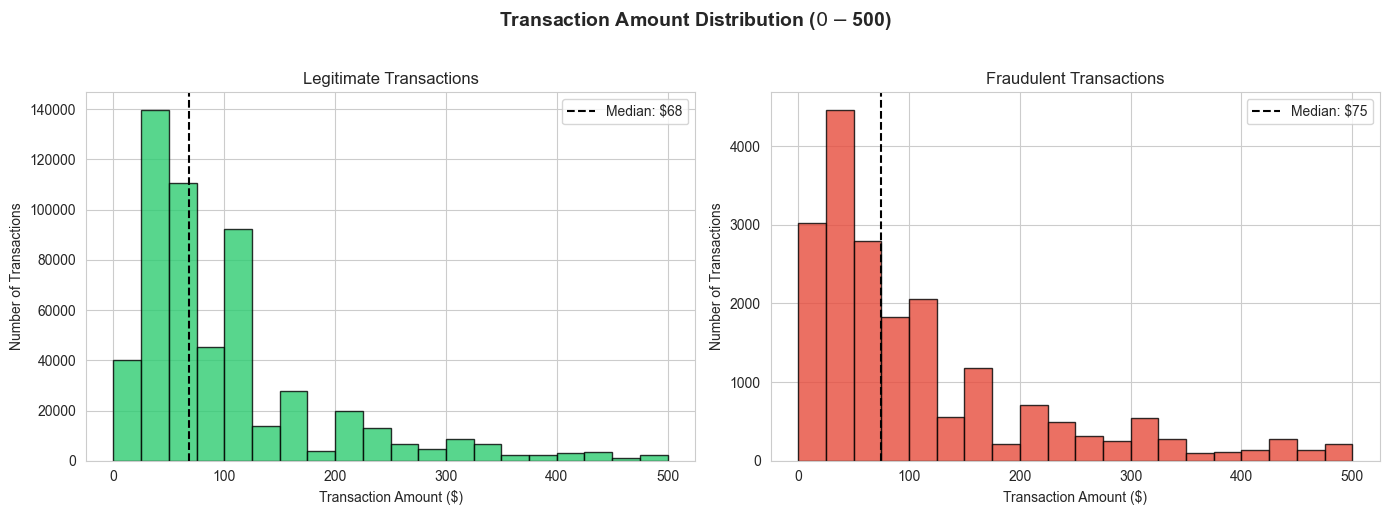

Transactions under $500: Legitimate 96.2% | Fraud 95.1%


In [13]:
# Stakeholder-friendly: Transaction amounts in dollars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
bins = np.arange(0, 525, 25)  # $0 to $500 in $25 bins

# Legitimate transactions
legit_amt = df[df['isFraud'] == 0]['TransactionAmt']
axes[0].hist(legit_amt, bins=bins, color='#2ecc71', edgecolor='black', alpha=0.8)
axes[0].set_title('Legitimate Transactions')
axes[0].set_xlabel('Transaction Amount ($)')
axes[0].set_ylabel('Number of Transactions')
axes[0].axvline(x=legit_amt.median(), color='black', linestyle='--', 
                label=f'Median: ${legit_amt.median():,.0f}')
axes[0].legend()

# Fraudulent transactions
fraud_amt = df[df['isFraud'] == 1]['TransactionAmt']
axes[1].hist(fraud_amt, bins=bins, color='#e74c3c', edgecolor='black', alpha=0.8)
axes[1].set_title('Fraudulent Transactions')
axes[1].set_xlabel('Transaction Amount ($)')
axes[1].set_ylabel('Number of Transactions')
axes[1].axvline(x=fraud_amt.median(), color='black', linestyle='--', 
                label=f'Median: ${fraud_amt.median():,.0f}')
axes[1].legend()

plt.suptitle('Transaction Amount Distribution ($0-$500)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../../data/processed/amount_distribution_dollars.png', dpi=150, bbox_inches='tight')
plt.show()

# Show what % of transactions fall within this range
legit_pct = (legit_amt <= 500).mean() * 100
fraud_pct = (fraud_amt <= 500).mean() * 100
print(f"Transactions under $500: Legitimate {legit_pct:.1f}% | Fraud {fraud_pct:.1f}%")

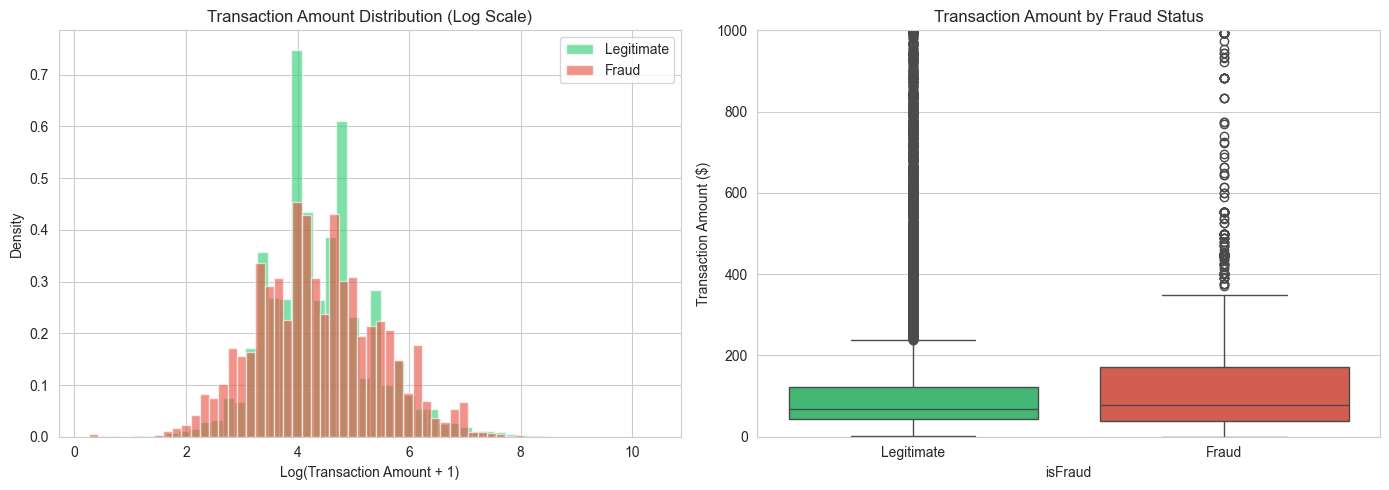

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution plot (log scale for visibility)
for fraud_val, color, label in [(0, '#2ecc71', 'Legitimate'), (1, '#e74c3c', 'Fraud')]:
    data = df[df['isFraud'] == fraud_val]['TransactionAmt']
    axes[0].hist(np.log1p(data), bins=50, alpha=0.6, color=color, label=label, density=True)

axes[0].set_xlabel('Log(Transaction Amount + 1)')
axes[0].set_ylabel('Density')
axes[0].set_title('Transaction Amount Distribution (Log Scale)')
axes[0].legend()

# Box plot comparison
df_sample = df.sample(n=min(50000, len(df)), random_state=42)
sns.boxplot(data=df_sample, x='isFraud', y='TransactionAmt', ax=axes[1], palette=['#2ecc71', '#e74c3c'])
axes[1].set_xticklabels(['Legitimate', 'Fraud'])
axes[1].set_ylabel('Transaction Amount ($)')
axes[1].set_title('Transaction Amount by Fraud Status')
axes[1].set_ylim(0, 1000)  # Focus on main distribution

plt.tight_layout()
plt.savefig('../../data/processed/amount_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

**Interpretation:**
- **Log-scale histogram**: Legitimate transactions concentrate sharply around ~$90 (log ~4.5), while fraud transactions show a flatter, wider distribution — suggesting fraud occurs across a broader range of amounts rather than clustering at common purchase values.
- **Boxplot**: Fraudulent transactions show a higher median and larger interquartile range, indicating they tend to involve higher and more variable amounts than legitimate ones.

## 7. Temporal Patterns: Fraud by Hour and Day

In [15]:
# TransactionDT is seconds from a reference time
# Extract hour of day and day of week
START_DATE = '2017-12-01'  # Common assumption for IEEE-CIS dataset
df['datetime'] = pd.to_datetime(START_DATE) + pd.to_timedelta(df['TransactionDT'], unit='s')
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['day'] = df['datetime'].dt.day

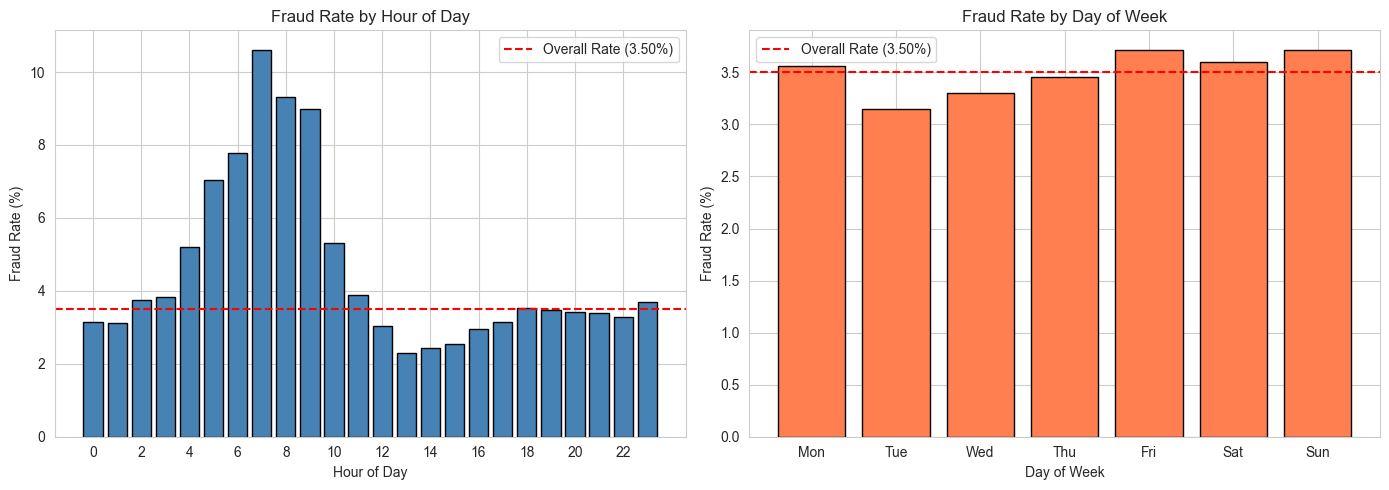

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fraud rate by hour
hourly_fraud = df.groupby('hour')['isFraud'].mean() * 100
axes[0].bar(hourly_fraud.index, hourly_fraud.values, color='steelblue', edgecolor='black')
axes[0].axhline(y=fraud_rate, color='red', linestyle='--', label=f'Overall Rate ({fraud_rate:.2f}%)')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Fraud Rate (%)')
axes[0].set_title('Fraud Rate by Hour of Day')
axes[0].set_xticks(range(0, 24, 2))
axes[0].legend()

# Fraud rate by day of week
daily_fraud = df.groupby('dayofweek')['isFraud'].mean() * 100
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].bar(days, daily_fraud.values, color='coral', edgecolor='black')
axes[1].axhline(y=fraud_rate, color='red', linestyle='--', label=f'Overall Rate ({fraud_rate:.2f}%)')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Fraud Rate (%)')
axes[1].set_title('Fraud Rate by Day of Week')
axes[1].legend()

plt.tight_layout()
plt.savefig('../../data/processed/temporal_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Summary of temporal patterns
print("TEMPORAL FRAUD PATTERNS")
print("="*50)
print(f"\nHighest fraud hours: {hourly_fraud.nlargest(3).index.tolist()}")
print(f"Lowest fraud hours: {hourly_fraud.nsmallest(3).index.tolist()}")
print(f"\nHighest fraud days: {[days[i] for i in daily_fraud.nlargest(3).index.tolist()]}")
print(f"Lowest fraud days: {[days[i] for i in daily_fraud.nsmallest(3).index.tolist()]}")

TEMPORAL FRAUD PATTERNS

Highest fraud hours: [7, 8, 9]
Lowest fraud hours: [13, 14, 15]

Highest fraud days: ['Fri', 'Sun', 'Sat']
Lowest fraud days: ['Tue', 'Wed', 'Thu']


## 8. Summary Statistics Table

In [18]:
# Create summary statistics
summary = pd.DataFrame({
    'Metric': [
        'Total Transactions', 'Fraud Transactions', 'Fraud Rate (%)',
        'Class Imbalance Ratio', 'Total Features', 'Features >50% Missing',
        'Avg Fraud Amount ($)', 'Avg Legitimate Amount ($)',
        'Peak Fraud Hour', 'Peak Fraud Day'
    ],
    'Value': [
        f"{total_count:,}", f"{fraud_count:,}", f"{fraud_rate:.2f}",
        f"1:{int((total_count-fraud_count)/fraud_count)}", f"{df.shape[1]}", f"{len(high_missing)}",
        f"{df[df['isFraud']==1]['TransactionAmt'].mean():.2f}",
        f"{df[df['isFraud']==0]['TransactionAmt'].mean():.2f}",
        f"{hourly_fraud.idxmax()}:00", f"{days[daily_fraud.idxmax()]}"
    ]
})
print(summary.to_string(index=False))

                   Metric   Value
       Total Transactions 590,540
       Fraud Transactions  20,663
           Fraud Rate (%)    3.50
    Class Imbalance Ratio    1:27
           Total Features     438
    Features >50% Missing     214
     Avg Fraud Amount ($)  149.24
Avg Legitimate Amount ($)  134.51
          Peak Fraud Hour    7:00
           Peak Fraud Day     Fri


## 9. Key Findings & Top Features for Feature Engineering

### Key Findings:
1. **Severe class imbalance** - Will need SMOTE or class weights
2. **Many high-missing features** - Consider dropping features >75% missing or using imputation
3. **Amount patterns differ** - Fraudulent transactions show different amount distributions
4. **Temporal signals exist** - Hour and day of week have fraud rate variations

### Top 10 Features for Feature Engineering:

In [19]:
# Save top features list
top_features_list = top_10_features.index.tolist()
print("TOP 10 FEATURES FOR FEATURE ENGINEERING")
print("="*50)
for i, feat in enumerate(top_features_list, 1):
    corr = top_10_features[feat]
    missing = missing_pct.get(feat, 0)
    print(f"{i:2}. {feat:<20} | Corr: {corr:.4f} | Missing: {missing:.1f}%")

# Save to file for reference
pd.DataFrame({'feature': top_features_list, 'correlation': top_10_features.values}).to_csv(
    '../../data/processed/top_features.csv', index=False
)
print("\n[Saved to data/processed/top_features.csv]")

TOP 10 FEATURES FOR FEATURE ENGINEERING
 1. V257                 | Corr: 0.3831 | Missing: 77.9%
 2. V246                 | Corr: 0.3669 | Missing: 77.9%
 3. V244                 | Corr: 0.3641 | Missing: 77.9%
 4. V242                 | Corr: 0.3606 | Missing: 77.9%
 5. V201                 | Corr: 0.3280 | Missing: 76.3%
 6. V200                 | Corr: 0.3188 | Missing: 76.3%
 7. V189                 | Corr: 0.3082 | Missing: 76.3%
 8. V188                 | Corr: 0.3036 | Missing: 76.3%
 9. V258                 | Corr: 0.2972 | Missing: 77.9%
10. V45                  | Corr: 0.2818 | Missing: 28.6%

[Saved to data/processed/top_features.csv]


## 10. Cost Assumptions for Modeling

In fraud detection, not all errors cost the same. A **False Negative** (missed fraud) results in direct financial loss, while a **False Positive** (legitimate transaction flagged) incurs operational review costs. These asymmetric costs will drive threshold tuning and model evaluation in Phase 3.

In [20]:
# Cost assumptions derived from EDA findings
fraud_median = df[df['isFraud'] == 1]['TransactionAmt'].median()
fraud_mean = df[df['isFraud'] == 1]['TransactionAmt'].mean()
legit_median = df[df['isFraud'] == 0]['TransactionAmt'].median()

# Industry benchmark for manual review cost
manual_review_cost = 10.00

print("COST ASSUMPTIONS FOR MODELING")
print("=" * 60)
print(f"\nFalse Negative cost (missed fraud):")
print(f"  Median fraud amount:  ${fraud_median:,.2f}  <-- RECOMMENDED")
print(f"  Mean fraud amount:    ${fraud_mean:,.2f}  (skewed by outliers)")
print(f"\nFalse Positive cost (manual review):")
print(f"  Industry benchmark:   ${manual_review_cost:,.2f}  (analyst time per case)")
print(f"\nCost ratio (FN : FP):   {fraud_median / manual_review_cost:.1f} : 1")
print(f"\nInterpretation:")
print(f"  Missing one fraud costs ~{fraud_median / manual_review_cost:.0f}x more than")
print(f"  unnecessarily reviewing one legitimate transaction.")
print(f"\n  These costs will inform:")
print(f"  - sample_weight / scale_pos_weight in XGBoost")
print(f"  - Probability threshold optimization")
print(f"  - Business-value-based model comparison")

COST ASSUMPTIONS FOR MODELING

False Negative cost (missed fraud):
  Median fraud amount:  $75.00  <-- RECOMMENDED
  Mean fraud amount:    $149.24  (skewed by outliers)

False Positive cost (manual review):
  Industry benchmark:   $10.00  (analyst time per case)

Cost ratio (FN : FP):   7.5 : 1

Interpretation:
  Missing one fraud costs ~8x more than
  unnecessarily reviewing one legitimate transaction.

  These costs will inform:
  - sample_weight / scale_pos_weight in XGBoost
  - Probability threshold optimization
  - Business-value-based model comparison


---
**Next Steps**: Use these top features as starting point for feature engineering in Phase 2.